<a href="https://colab.research.google.com/github/basselkassem/nlp-toolkit/blob/master/5_decoder_encoder_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import time
import os
from itertools import chain
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding, Input, Dense, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

%matplotlib inline
print(tf.__version__)

2.2.0


# Download and read data

In [3]:
!wget http://www.manythings.org/anki/ara-eng.zip

--2020-06-25 17:13:09--  http://www.manythings.org/anki/ara-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 172.67.173.198, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443921 (434K) [application/zip]
Saving to: ‘ara-eng.zip’

ara-eng.zip         100%[===================>] 433.52K   504KB/s    in 0.9s    

2020-06-25 17:13:11 (504 KB/s) - ‘ara-eng.zip’ saved [443921/443921]



In [4]:
from zipfile import ZipFile
with ZipFile('ara-eng.zip', 'r') as zipf:
  zipf.extractall()

In [5]:
def read_data(file_path = 'ara.txt'):
  src_senteces, dist_senteces = [], []
  for line in open(file_path, 'r', encoding='utf8'):
    sentences = line.split('\t')
    src_sent = sentences[0].strip()
    dis_sent = sentences[1].strip()
    src_senteces.append(src_sent)
    dist_senteces.append(dis_sent)
  return src_senteces, dist_senteces
eng_sentences, ara_sentences = read_data()
print(len(eng_sentences), len(ara_sentences))

11320 11320


In [6]:
ind = np.random.randint(0, len(eng_sentences))
print(eng_sentences[ind], ara_sentences[ind])

That factory makes toys. ذلك المصنع ينتج الألعاب.


# Global variables

In [7]:
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PAD_TOKEN = '<pad>'

BATCH_SIZE = 64
LATENT_DIM = 1024
EPOCHS = 10
DROP_OUT = 0.1

ENC_EMBEDDING_DIM = 256
DEC_EMBEDDING_DIM = 256

# Data preprocessing

In [8]:
ar_pattern = '[^' + 'أ-يَُِّْإًٌٍلإلأ~إأآلآلآـ!?.,' + ']+'
en_pattern = '[^' + 'a-zA-Z!?.,' + ']+'

In [9]:
def process_sentence(sentence, lang):
  processed_sent = sentence.lower()
  if lang == 'ar':
    processed_sent = re.sub(ar_pattern, ' ', processed_sent)
    return processed_sent.strip()
  else:
    processed_sent = re.sub(en_pattern, ' ', processed_sent)
    return processed_sent.strip()

def process_sentences(sentences, lang ='ar'):
  processed_sents = [process_sentence(sent, lang) for sent in sentences]
  return processed_sents

src_sentences = process_sentences(eng_sentences, lang ='en')
dist_sentences = process_sentences(ara_sentences, lang ='ar')
ind = np.random.randint(0, len(src_sentences))
print(src_sentences[ind])
print(dist_sentences[ind])

everything is better without you.
كل شي أفضل من دونك.


In [10]:
def tokenize(sentences):
  tokenizer = TreebankWordTokenizer()
  sents = [[START_TOKEN] + tokenizer.tokenize(sentence) + [END_TOKEN] for sentence in sentences]
  max_length = np.max([len(sent) for sent in sents])
  return sents, max_length

def create_word2ind(sentences):
  word2ind, ind2word = {}, []
  words = chain(*sentences)
  vocabs = sorted(set(words), reverse = False)
  word2ind[PAD_TOKEN] = 0
  ind2word.append(PAD_TOKEN)
  for i, word in enumerate(vocabs):
    word2ind[word] = i + 1
    ind2word.append(word)
  return word2ind, ind2word

def pad_sentences(sentences, word2ind, max_length):
  seqs = []
  lengths = []
  for sent in sentences:
    seq = [word2ind[token] for token in sent] + [0] * (max_length - len(sent))
    seqs.append(seq)
    lengths.append(len(sent))
  return seqs, lengths

In [11]:
def create_sequencs(sentences):
  seqs, max_len,  = tokenize(sentences)
  word2ind, ind2word = create_word2ind(seqs)
  seqs, lengths = pad_sentences(seqs, word2ind, max_len)
  return seqs, word2ind, ind2word, max_len, lengths

src_seqs, src_word2ind, src_ind2word, src_max_len, src_lengths = create_sequencs(src_sentences)
dist_seqs, dist_word2ind, dist_ind2word, dist_max_len, dist_lengths = create_sequencs(dist_sentences)

In [12]:
def convert2text(seqs, ind2word):
  sents = []
  for seq in seqs:
    sent =  []
    for ind in seq:
      token = ind2word[ind]
      if START_TOKEN != token and END_TOKEN!= token and PAD_TOKEN != token:
        sent.append(token)
    sents.append(' '.join(sent))
  return sents

In [13]:
def create_dataset(src_seqs, dist_seqs, batch_size = 64):
  buffer_size = len(src_seqs)
  dataset = tf.data.Dataset.from_tensor_slices((src_seqs, dist_seqs)).shuffle(buffer_size)
  return dataset.batch(batch_size)

dataset = create_dataset(src_seqs, dist_seqs, BATCH_SIZE)

In [81]:
src_vocabs_size = len(src_word2ind.keys())
dist_vocabs_size = len(dist_word2ind.keys())

steps_per_epoch = len(dist_seqs) // BATCH_SIZE
sample_src_seqs, sample_dist_seqs = next(iter(dataset))

sentences = [
  'how to run a car?',
  'what kind of food do you like?',
  'he comes from syria.',
  'he has a lot of money.', 
  'it is good.', 
  'do you have friends?',
  'it is a nice weather.', 
  'they are very bad people.',
  'do you need help?',
]
ind = np.random.randint(len(src_sentences))
sent2trans = src_sentences[ind]

# Encoder decoder architecture


## seq2seq
The [encoder-decoder architecture](https://arxiv.org/pdf/1406.1078.pdf) is used to encode the input sequece into hidden representation, then decode this representation to ouput sequence.

$p(y_1, y_2, ...,y_J|x_1, x_2, ..., x_I) = \prod_{i=1}^{J}p(y_i|v,x_1,...x_I)$
###encoder
$\forall i\in [1,I]; h_i = f(h_{i-1}, x_i)$, $v = h_I$
### decoder
$\forall j\in [1, J]; s_j = g(s_{j-1}, [y_{i-1}, v] )$
### prediction
$p(y_j|x_1, x_2, ..., x_I) = softmax(Us_j + b)$

## Encoder-Decoder(GRU)

In [15]:
class Encoder(Model):
  def __init__(self, vocabs_size, embedding_dim, enc_units, batch_size, dp = 0.25):
    super(Encoder, self).__init__()
    self.units = enc_units
    self.batch_size = batch_size
    self.embedding = Embedding(input_dim = vocabs_size, output_dim = embedding_dim)
    self.nn_layer = GRU(
        units = self.units,
        return_state = True, 
        return_sequences = True, 
        dropout = dp, 
    )
  def call(self, x, init_hidden_state):
    x = self.embedding(x)
    output, hidden_state = self.nn_layer(x, initial_state = init_hidden_state)
    return output, hidden_state
  
  def init_state(self):
    return tf.zeros(( self.batch_size, self.units))

encoder = Encoder(src_vocabs_size, ENC_EMBEDDING_DIM, LATENT_DIM, BATCH_SIZE, DROP_OUT)
sample_enc_init_state = encoder.init_state()
enc_output, enc_state = encoder(sample_src_seqs, sample_enc_init_state)

print('encoder output:', enc_output.shape)
print('encoder state:', enc_state.shape)

encoder output: (64, 42, 1024)
encoder state: (64, 1024)


In [25]:
class Decoder(Model):
  def __init__(self, vocabs_size, embedding_dim, dec_units, batch_size, dp = 0.25):
    super(Decoder, self).__init__()
    self.units = dec_units
    self.batch_size = batch_size

    self.embedding = Embedding(input_dim = vocabs_size, output_dim = embedding_dim)
    self.nn_layer = GRU(
        units = self.units,
        return_state = True, 
        return_sequences = True, 
        dropout = dp, 
    )
    self.fc = Dense(vocabs_size)
  
  def call(self, x, dec_state, enc_state):
    x = self.embedding(x)
    context_vector = tf.expand_dims(enc_state, 1)
    x = tf.concat([context_vector, x], axis = -1)
    x, state = self.nn_layer(x, initial_state = dec_state)
    x = tf.reshape(x, (-1, x.shape[2]))
    output = self.fc(x)
    return output, state

decoder = Decoder(dist_vocabs_size, DEC_EMBEDDING_DIM, LATENT_DIM, BATCH_SIZE, DROP_OUT)
dec_output, dec_state = decoder(tf.random.uniform((BATCH_SIZE, 1)), enc_state, enc_state)
print('decoder out:', dec_output.shape)
print('decoder state:', dec_state.shape)

decoder out: (64, 11663)
decoder state: (64, 1024)


In [26]:
optimizer = Adam(learning_rate = 0.001)
checkpoint_dir = 'enc-dec-lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [27]:
loss_objective = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_func(y_true, y_hat):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_objective(y_true, y_hat)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

@tf.function
def train_step(src_seqs, y_true, enc_init_state):
  loss = 0
  with tf.GradientTape() as tape:
    _, enc_state = encoder(src_seqs, enc_init_state)

    dec_state = enc_state
    dec_input = tf.expand_dims([dist_word2ind[START_TOKEN]] * BATCH_SIZE, 1)

    for t in range(1, dist_max_len):
      y_hat, dec_state = decoder(dec_input, dec_state, enc_state)
      loss += loss_func(y_true[:, t], y_hat)
      dec_input = tf.expand_dims(y_true[:, t], 1)
  
    batch_loss = loss /int(y_true.shape[1])
    variables = decoder.trainable_variables + encoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return batch_loss

def train():
  for epoch in range(1, EPOCHS + 1):
    start = time.time()
    total_loss = 0
    enc_init_state = encoder.init_state()
    for batch, (src_seqs, y_true) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(src_seqs, y_true, enc_init_state)
      total_loss += batch_loss
      if batch % 50 == 0:
        print('Epoch {}, Batch {}, Loss {:.4f}'.format(epoch, batch, batch_loss.numpy()))
    if epoch % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} total loss {:.4f}'.format(epoch, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))


train()

Epoch 1, Batch 0, Loss 1.5317
Epoch 1, Batch 50, Loss 0.8024
Epoch 1, Batch 100, Loss 0.8258
Epoch 1, Batch 150, Loss 0.7419
Epoch 1 total loss 0.8546
Time taken for 1 epoch 137.42 sec

Epoch 2, Batch 0, Loss 0.6169
Epoch 2, Batch 50, Loss 0.5802
Epoch 2, Batch 100, Loss 0.7067
Epoch 2, Batch 150, Loss 0.6343
Epoch 2 total loss 0.6321
Time taken for 1 epoch 89.22 sec

Epoch 3, Batch 0, Loss 0.4329
Epoch 3, Batch 50, Loss 0.4428
Epoch 3, Batch 100, Loss 0.4297
Epoch 3, Batch 150, Loss 0.4664
Epoch 3 total loss 0.4694
Time taken for 1 epoch 89.23 sec

Epoch 4, Batch 0, Loss 0.3426
Epoch 4, Batch 50, Loss 0.3145
Epoch 4, Batch 100, Loss 0.3673
Epoch 4, Batch 150, Loss 0.3280
Epoch 4 total loss 0.3342
Time taken for 1 epoch 89.63 sec

Epoch 5, Batch 0, Loss 0.2271
Epoch 5, Batch 50, Loss 0.2005
Epoch 5, Batch 100, Loss 0.2437
Epoch 5, Batch 150, Loss 0.2666
Epoch 5 total loss 0.2349
Time taken for 1 epoch 88.97 sec

Epoch 6, Batch 0, Loss 0.1392
Epoch 6, Batch 50, Loss 0.1796
Epoch 6, Batc

In [28]:
def translate(sentence):
  seqs, max_len,  = tokenize([sentence])
  seqs, lengths = pad_sentences(seqs, src_word2ind, src_max_len)
  seqs = tf.convert_to_tensor(seqs)
  enc_init_state = tf.zeros((1, LATENT_DIM))
  _, enc_state = encoder(seqs, enc_init_state)

  dec_input = tf.expand_dims([dist_word2ind['<start>']] , 0)
  dec_state = enc_state
  result = ''
  for t in range(dist_max_len):
    y_hat, dec_state = decoder(dec_input, dec_state, enc_state)
    predicted_id = tf.argmax(y_hat[0]).numpy()
    result += dist_ind2word[predicted_id] + ' '
    if dist_ind2word[predicted_id] == '<end>':
      return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
for sent in sentences:
  print(sent,'--->\t', translate(sent))

how to run a car? --->	 كيف وصل قيادة <end> 
what kind of food do you like? --->	 أي نوع من الشطائر تريد <end> 
he comes from syria --->	 يلعب كل من عمره . <end> 
he has a lot of money --->	 لديه الكثير من المال . <end> 
it is good --->	 إن ذلك جيد . <end> 
do you have friends ? --->	 هل لديك أي أقلام <end> 
it is a nice weather . --->	 انها رائعة جميل . <end> 
they are very bad people . --->	 إنهما فخوران كبار جداً . <end> 
do you need help ? --->	 هل تريد أن تفعلها <end> 


In [29]:
ind = np.random.randint(len(src_sentences))
sent = src_sentences[ind]
print(sent,'--->\t', translate(sent))

tom is drinking directly from the faucet. --->	 توم يشرب من الصنبور مباشرة <end> 


##Encoder-Decoder(Bidirectional)

In [30]:
class Encoder(Model):
  def __init__(self, vocabs_size, embedding_dim, enc_units, batch_size, dp = 0.1):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.batch_size = batch_size

    self.embeddig = Embedding(input_dim = vocabs_size, output_dim = embedding_dim)

    self.dyrnn_layer = Bidirectional(
        GRU(
          units = enc_units,
          return_state = True,
          dropout = dp,
        ),
        merge_mode = 'concat',
    )

  def call(self, x, init_state):
    x = self.embeddig(x)
    output, forward_state, backward_state = self.dyrnn_layer(x, initial_state = init_state)
    state = [forward_state, backward_state]
    return output, state

  def init_states(self):
    return [tf.zeros((self.batch_size, self.enc_units)) for i in range(2)]
  
encoder = Encoder(src_vocabs_size, ENC_EMBEDDING_DIM, LATENT_DIM, BATCH_SIZE, DROP_OUT)
sample_init_state = encoder.init_states()
enc_output, (enc_forward_state, enc_backward_state) = encoder(sample_src_seqs, sample_init_state)

print ('Encoder output: (batch size, sequence length, units * 2) {}'.format(enc_output.shape))
print ('Encoder forward state: (batch size, units) {}'.format(enc_forward_state.shape))
print ('Encoder backward state: (batch size, units) {}'.format(enc_backward_state.shape))

Encoder output: (batch size, sequence length, units * 2) (64, 2048)
Encoder forward state: (batch size, units) (64, 1024)
Encoder backward state: (batch size, units) (64, 1024)


In [31]:
class Decoder(Model):
  def __init__(self, vocabs_size, embedding_dim, dec_units, batch_size, dp = 0.1):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.batch_size = batch_size

    self.embedding = Embedding(input_dim = vocabs_size, output_dim = embedding_dim)
    self.dyrnn_layer = Bidirectional(
        GRU(
            units = self.dec_units,
            return_sequences = True,
            return_state = True,
            dropout = dp,
        )
    )
    self.fc = Dense(units = vocabs_size)

  def call(self, x, dec_states, enc_states):
    x = self.embedding(x)
    context_vector = tf.concat(enc_states, axis = 1)
    context_vector = tf.expand_dims(context_vector, 1)
    x = tf.concat([context_vector, x], axis = -1)
    output, forward_state, backward_state = self.dyrnn_layer(x, initial_state = dec_states)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, [forward_state, backward_state]
  
  def init_states(self):
    return [tf.zeros((self.batch_size, self.dec_units)) for i in range(2)]

decoder = Decoder(dist_vocabs_size, DEC_EMBEDDING_DIM, LATENT_DIM, BATCH_SIZE, DROP_OUT)
dec_init_states = decoder.init_states()
dec_sampel_input = tf.random.uniform((BATCH_SIZE, 1))
decoder_output, (dec_forward_state, dec_backward_state) = decoder(dec_sampel_input, [enc_forward_state, enc_backward_state], dec_init_states)
print ('Decoder output: (batch_size, vocab size) {}'.format(decoder_output.shape))
print ('Decoder forward_state: (batch_size, units) {}'.format(dec_forward_state.shape))
print ('Decoder backward_state: (batch_size, units) {}'.format(dec_backward_state.shape))

Decoder output: (batch_size, vocab size) (64, 11663)
Decoder forward_state: (batch_size, units) (64, 1024)
Decoder backward_state: (batch_size, units) (64, 1024)


In [32]:
optimizer = Adam(learning_rate = 0.001)
loss_objective = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(y_true, y_hat):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_objective(y_true, y_hat)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [33]:
checkpoint_dir = 'bidirectional_GRU'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    optimizer = optimizer, 
    encoder = encoder,
    decoder = decoder,
)

In [36]:
@tf.function
def train_step(src_seqs, y_true, enc_init_state):
  loss = 0
  with tf.GradientTape() as tape:
    enc_out, enc_states = encoder(src_seqs, enc_init_state)

    dec_states = enc_states
    dec_input = tf.expand_dims([dist_word2ind[START_TOKEN]] * BATCH_SIZE, 1)
    for t in range(1,  y_true.shape[1]):
      y_hat, dec_states = decoder(dec_input, dec_states, enc_states)
      loss += loss_function(y_true[:, t], y_hat)
      dec_input = tf.expand_dims(y_true[:, t], 1)
    
    batch_loss = loss/ int(y_true.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return batch_loss

In [37]:
def train():
  for epoch in range(1, EPOCHS + 1):
    start = time.time()

    enc_init_states = encoder.init_states()
    total_loss = 0
    for (batch, (src, dist)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(src, dist, enc_init_states)
      total_loss += batch_loss
      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch, batch, batch_loss.numpy()))
    if epoch % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))
    
train()

Epoch 1 Batch 0 Loss 1.4230
Epoch 1 Batch 100 Loss 0.8553
Epoch 1 Loss 0.9277
Time taken for 1 epoch 279.45 sec

Epoch 2 Batch 0 Loss 0.8202
Epoch 2 Batch 100 Loss 0.7125
Epoch 2 Loss 0.7493
Time taken for 1 epoch 188.63 sec

Epoch 3 Batch 0 Loss 0.6793
Epoch 3 Batch 100 Loss 0.5849
Epoch 3 Loss 0.6063
Time taken for 1 epoch 186.13 sec

Epoch 4 Batch 0 Loss 0.4476
Epoch 4 Batch 100 Loss 0.4804
Epoch 4 Loss 0.4454
Time taken for 1 epoch 190.15 sec

Epoch 5 Batch 0 Loss 0.2775
Epoch 5 Batch 100 Loss 0.2884
Epoch 5 Loss 0.2885
Time taken for 1 epoch 186.92 sec

Epoch 6 Batch 0 Loss 0.1767
Epoch 6 Batch 100 Loss 0.1917
Epoch 6 Loss 0.1740
Time taken for 1 epoch 189.33 sec

Epoch 7 Batch 0 Loss 0.1339
Epoch 7 Batch 100 Loss 0.1258
Epoch 7 Loss 0.1104
Time taken for 1 epoch 187.38 sec

Epoch 8 Batch 0 Loss 0.0770
Epoch 8 Batch 100 Loss 0.0783
Epoch 8 Loss 0.0743
Time taken for 1 epoch 188.94 sec

Epoch 9 Batch 0 Loss 0.0544
Epoch 9 Batch 100 Loss 0.0524
Epoch 9 Loss 0.0549
Time taken for 1 e

In [38]:
def translate(sentence):
  seqs, max_len,  = tokenize([sentence])
  seqs, lengths = pad_sentences(seqs, src_word2ind, src_max_len)
  seqs = tf.convert_to_tensor(seqs)

  enc_init_state = [tf.zeros((1, LATENT_DIM)) for _ in range(2)]
  enc_out, enc_states = encoder(seqs, enc_init_state)

  dec_input = tf.expand_dims([dist_word2ind['<start>']] , 0)
  dec_states = enc_states
  result = ''
  for t in range(dist_max_len):
    y_hat, dec_states = decoder(dec_input, dec_states, enc_states)
    predicted_id = tf.argmax(y_hat[0]).numpy()
    result += dist_ind2word[predicted_id] + ' '
    if dist_ind2word[predicted_id] == '<end>':
      return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

for sent in sentences:
  print(sent,'--->\t', translate(sent))

how to run a car? --->	 كيف حال سيارتك <end> 
what kind of food do you like? --->	 ما نوع الجراحة المفضّل <end> 
he comes from syria --->	 لقد طلب لنا شرائح اللحم <end> 
he has a lot of money --->	 عنده كثيرٌ من المال . <end> 
it is good --->	 إنه لطيف . <end> 
do you have friends ? --->	 هل لديك واحد <end> 
it is a nice weather . --->	 الجو حار جداً <end> 
they are very bad people . --->	 إنهم كبار جداً لكنه يمكننا . <end> 
do you need help ? --->	 هل تحب أن أساعدك <end> 


In [40]:
ind = np.random.randint(len(src_sentences))
sent = src_sentences[ind]
print(sent,'--->\t', translate(sent))

i think it is best not to be impolite. --->	 أظن أن من الأفضل ألا تكون وقِحًا . <end> 


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Encoder decoder architecture with attention mechanism

The [attention mechanism](https://arxiv.org/pdf/1508.04025v5.pdf) works as the following:
* encoder takes a source sentence, then it generates tow things: a representation of the input $(h_s^-)$ and a state that carries information about the whole seqeunce
* at each time step we initailize the decoder state with encoder state
* attentions weights are computed using the formula: $\alpha_{ts}=\frac{exp(score(h_t, h_s^-))}{\sum_{j=0}^Jexp(score(h_t, h_j^-))}$, $h_t$ is the hidden state of the decoder
* score function compute similarity between the state of the decoder and the output of the encoder as: $score(h_t, h_s^-) =v_a^Ttanh(W_1h_t+W_2h_s^-)$
* context vector is computed as: $c_t = \sum_s\alpha_{ts}h_s^-$
* attention vector is computed as: $a_t = f(c_t, h_t) = tanh(W_c[c_t;h_t])$

In [95]:
class Encoder(Model):

  def __init__(self, batch_size, latent_dim, embedding_dim, dp):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.units = latent_dim

    self.embedding = Embedding(input_dim = src_vocabs_size, output_dim = embedding_dim)
    self.rnn_layer = GRU(units = self.units, dropout = dp, return_sequences=True, return_state=True)

  def call(self, x, init_state):
    x = self.embedding(x)
    output, state = self.rnn_layer(x, initial_state = init_state)
    return output, state
  
  def init_state(self):
    return tf.zeros((self.batch_size, self.units))

encoder = Encoder(BATCH_SIZE, LATENT_DIM, ENC_EMBEDDING_DIM, DROP_OUT)
init_state = encoder.init_state()
enc_out, enc_state = encoder(sample_src_seqs, init_state)
print('encoder output (batch_size, src_len, latent_dim)', enc_out.shape)
print('encoder state (batch_size, latent_dim)', enc_state.shape)

encoder output (batch_size, src_len, latent_dim) (64, 42, 1024)
encoder state (batch_size, latent_dim) (64, 1024)


In [96]:
class Attention(tf.keras.layers.Layer):

  def __init__(self, units):
    super(Attention, self).__init__()
    self.units = units
    self.W1 = Dense(self.units)
    self.W2 = Dense(self.units)
    self.V = Dense(1)
  
  def score(self, enc_state, enc_output):
    state = tf.expand_dims(enc_state, 1)
    score = self.V(tf.nn.tanh(self.W1(state) + self.W2(enc_output)))
    return score

  def call(self, enc_state, enc_output):
    score = self.score(enc_state, enc_output)
    attention_weights = tf.nn.softmax(score, axis = 1)
    context_vec = tf.reduce_sum(attention_weights * enc_output, axis = 1)
    return context_vec, attention_weights

attention = Attention(10)
context_vec, attention_weights = attention(enc_state, enc_out)
print('context_vector:', context_vec.shape)
print('attention_weights:', attention_weights.shape)

context_vector: (64, 1024)
attention_weights: (64, 42, 1)


In [97]:
class Decoder(Model):
  def __init__(self, batch_size, latent_dim, embedding_dim, dp):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.units = latent_dim

    self.embeddings = Embedding(input_dim = dist_vocabs_size, output_dim = embedding_dim)
    self.rnn_layer = GRU(units = self.units, return_sequences = True, return_state=True, dropout=dp, recurrent_initializer='glorot_uniform')
    self.fc = Dense(units = dist_vocabs_size)
    self.attention = Attention(units = latent_dim)
  
  def call(self, x, dec_state, enc_output, enc_state):
    context_vec, attention_weights = self.attention(dec_state, enc_output)
    x = self.embeddings(x)
    x = tf.concat([tf.expand_dims(context_vec, 1), x], axis = -1)
    output, state = self.rnn_layer(x, initial_state = enc_state)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(BATCH_SIZE, LATENT_DIM, DEC_EMBEDDING_DIM, DROP_OUT)
dec_output, dec_state, attention_weights = decoder(tf.random.uniform((BATCH_SIZE, 1)), enc_state, enc_out, enc_state)
print('decoder output:', dec_output.shape)
print('decoder state:', dec_state.shape)
print('attention weights:', attention_weights.shape)

decoder output: (64, 11663)
decoder state: (64, 1024)
attention weights: (64, 42, 1)


In [98]:
optimizer = Adam(learning_rate = 0.001)
checkpoint_dir = 'attention_model'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoder = encoder, decoder = decoder)

In [99]:
loss_objective = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(y_true, y_hat):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_objective(y_true, y_hat)
  mask = tf.cast(mask, loss_.dtype)
  loss_ = loss_ * mask
  return tf.reduce_mean(loss_)

In [100]:
@tf.function
def train_step(src_input, enc_state, y_true):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_state = encoder(src_input, enc_state)

    dec_input = tf.expand_dims([dist_word2ind['<start>']] * BATCH_SIZE, 1)
    dec_state = enc_state
    for t in range(1, y_true.shape[1]):
      y_hat, dec_state, _ = decoder(dec_input, dec_state, enc_output, enc_state)
      loss += loss_function(y_true[:, t], y_hat)
      dec_input = tf.expand_dims(y_true[:, t], 1)

    batch_loss = loss / BATCH_SIZE
    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return batch_loss

In [101]:
def train():
  for epoch in range(1, EPOCHS + 1):
    start = time.time()
    init_enc_state = encoder.init_state()
    total_loss = 0
    for batch, (src_sent, dist_sent) in enumerate(dataset.take(steps_per_epoch)):    
      batch_loss = train_step(src_sent, init_enc_state, dist_sent)
      total_loss += batch_loss
      if batch % 50 == 0:
        print('Epoch {}, Batch {}, Loss {:.4f}'.format(epoch, batch, batch_loss.numpy()))
    if epoch % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} total loss {:.4f}'.format(epoch, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {:.2f} sec\n'.format(time.time() - start))
  
train()

Epoch 1, Batch 0, Loss 0.9077
Epoch 1, Batch 50, Loss 0.6466
Epoch 1, Batch 100, Loss 0.5612
Epoch 1, Batch 150, Loss 0.5720
Epoch 1 total loss 0.6208
Time taken for 1 epoch 220.86 sec

Epoch 2, Batch 0, Loss 0.5383
Epoch 2, Batch 50, Loss 0.5835
Epoch 2, Batch 100, Loss 0.5805
Epoch 2, Batch 150, Loss 0.5206
Epoch 2 total loss 0.5149
Time taken for 1 epoch 163.19 sec

Epoch 3, Batch 0, Loss 0.4684
Epoch 3, Batch 50, Loss 0.4737
Epoch 3, Batch 100, Loss 0.4575
Epoch 3, Batch 150, Loss 0.4848
Epoch 3 total loss 0.4572
Time taken for 1 epoch 163.30 sec

Epoch 4, Batch 0, Loss 0.3886
Epoch 4, Batch 50, Loss 0.3831
Epoch 4, Batch 100, Loss 0.3416
Epoch 4, Batch 150, Loss 0.3633
Epoch 4 total loss 0.3924
Time taken for 1 epoch 163.29 sec

Epoch 5, Batch 0, Loss 0.3265
Epoch 5, Batch 50, Loss 0.3203
Epoch 5, Batch 100, Loss 0.3094
Epoch 5, Batch 150, Loss 0.3304
Epoch 5 total loss 0.3215
Time taken for 1 epoch 164.57 sec

Epoch 6, Batch 0, Loss 0.2401
Epoch 6, Batch 50, Loss 0.2459
Epoch 6, 

In [89]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#!rm -R attention_model

In [90]:
def evaluate(sentence):
  attention_plot = np.zeros((dist_max_len, src_max_len))

  seqs, max_len,  = tokenize([sentence])
  padded_seqs, lengths = pad_sentences(seqs, src_word2ind, src_max_len)
  padded_seqs = tf.convert_to_tensor(padded_seqs)

  result = ''
  init_enc_state = [tf.zeros((1, LATENT_DIM))]

  enc_output, enc_state = encoder(padded_seqs, init_enc_state)
  dec_state = enc_state
  dec_input = tf.expand_dims([dist_word2ind['<start>']], 0)
  for t in range(dist_max_len):
    y_hat, dec_state, attention_weights = decoder(dec_input, dec_state, enc_output, enc_state)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    y_hat_id = tf.argmax(y_hat[0]).numpy()
    result = result + dist_ind2word[y_hat_id] + ' '
    if dist_ind2word[y_hat_id] == '<end>':
      return result, ' '.join(seqs[0]), attention_plot
    dec_input = tf.expand_dims([y_hat_id], 0)
  return result, ' '.join(seqs[0]), attention_plot


In [91]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap = 'viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  print(attention_plot.shape)
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  

Input: <start> how to run a car ? <end>
Predicted translation: كيف أصل إلى تقود سيارة <end> 
(40, 42)


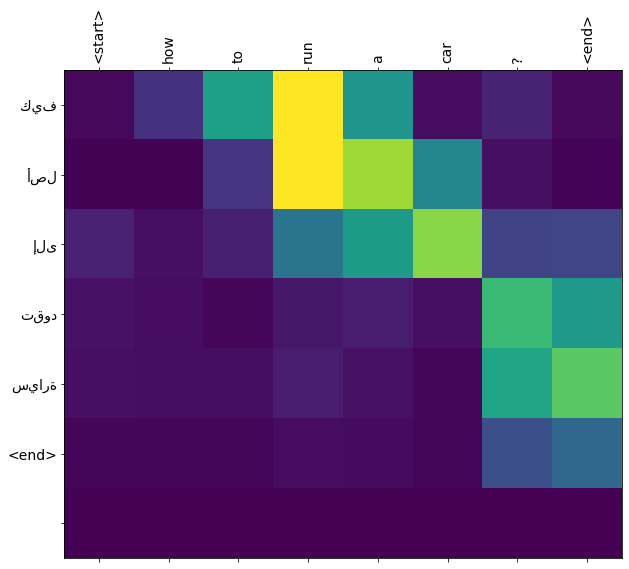

Input: <start> what kind of food do you like ? <end>
Predicted translation: أي نوع من أجل ذلك <end> 
(40, 42)


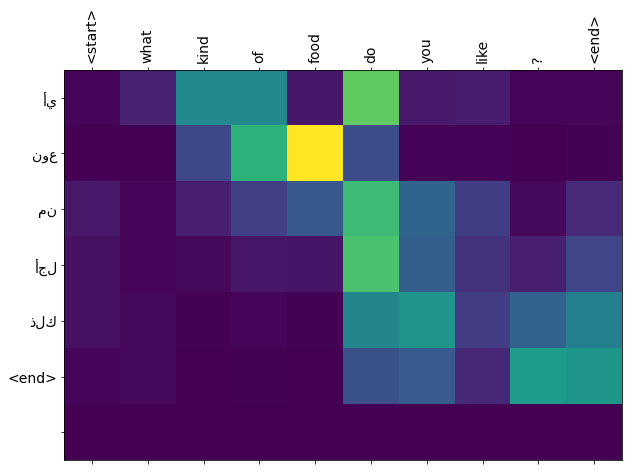

Input: <start> he comes from syria . <end>
Predicted translation: عاد من القمح . <end> 
(40, 42)


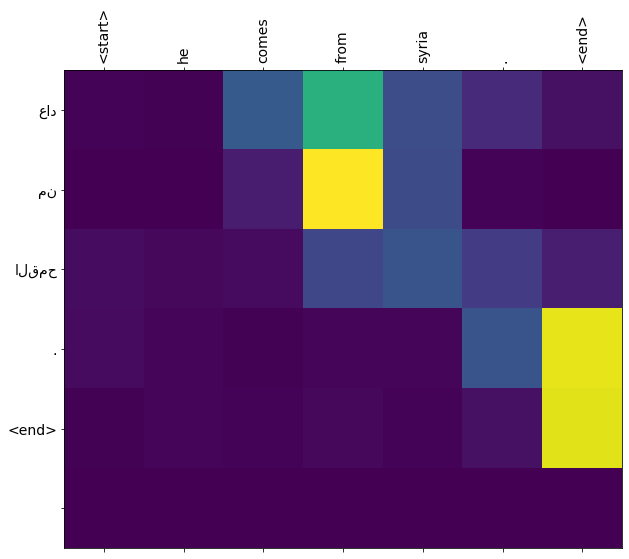

Input: <start> he has a lot of money . <end>
Predicted translation: لديه الكثير من المال . <end> 
(40, 42)


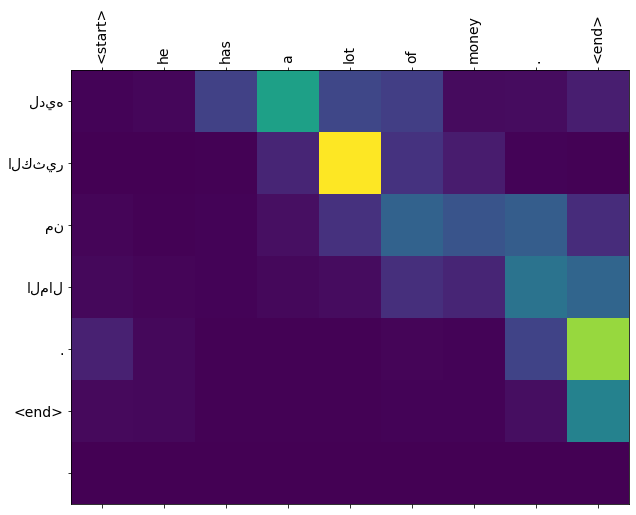

Input: <start> it is good . <end>
Predicted translation: إنها صناعية . <end> 
(40, 42)


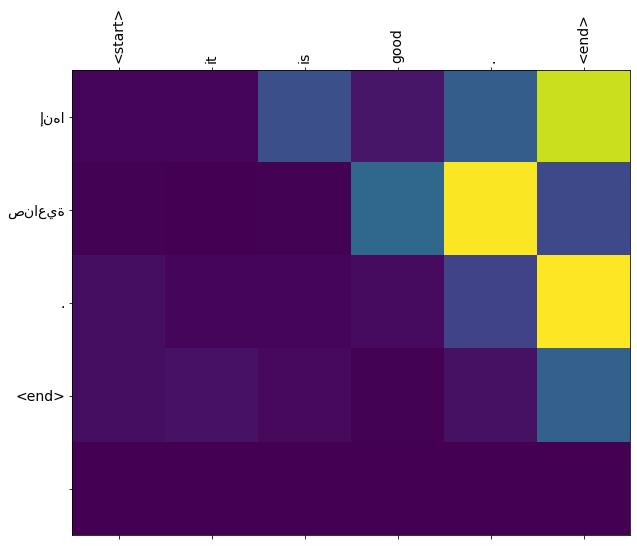

Input: <start> do you have friends ? <end>
Predicted translation: هل لديك كل شي <end> 
(40, 42)


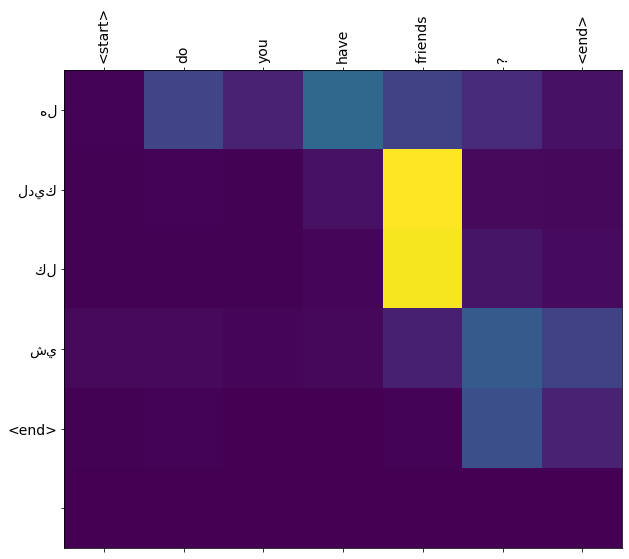

Input: <start> it is a nice weather . <end>
Predicted translation: إنها جميلة . <end> 
(40, 42)


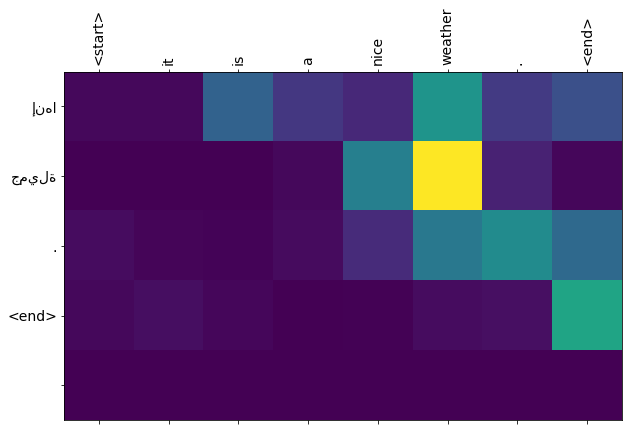

Input: <start> they are very bad people . <end>
Predicted translation: هم كبار جداً . <end> 
(40, 42)


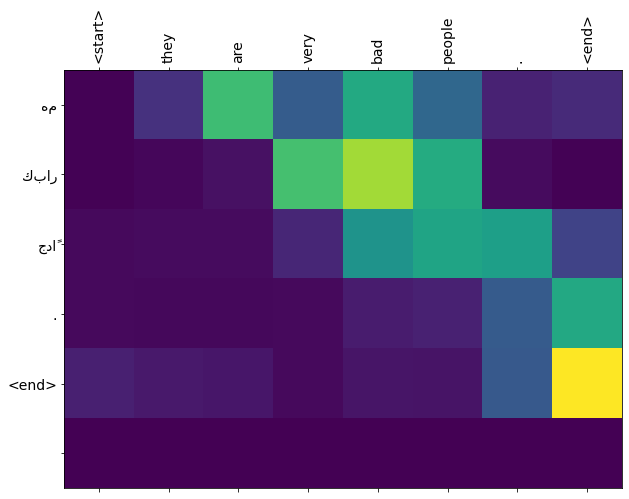

Input: <start> do you need help ? <end>
Predicted translation: هل تنوي أن نذهب <end> 
(40, 42)


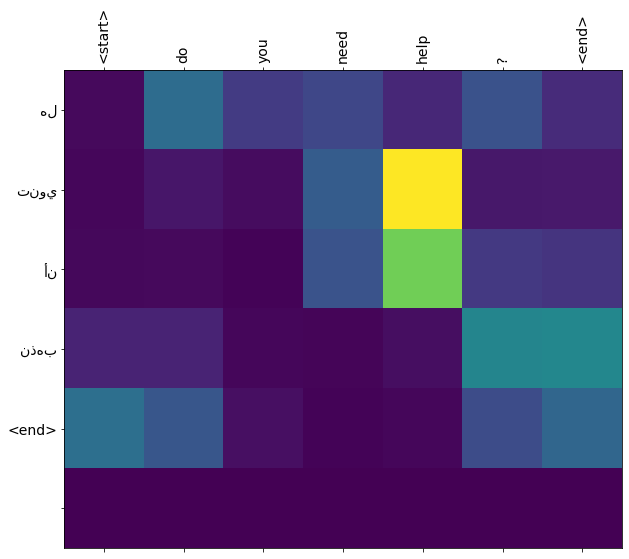

In [92]:
for sent in sentences:
  translate(sent)

Input: <start> if we leave now , we should make it . <end>
Predicted translation: إن غادرنا الآن فسنصل على الوقت . <end> 
(40, 42)


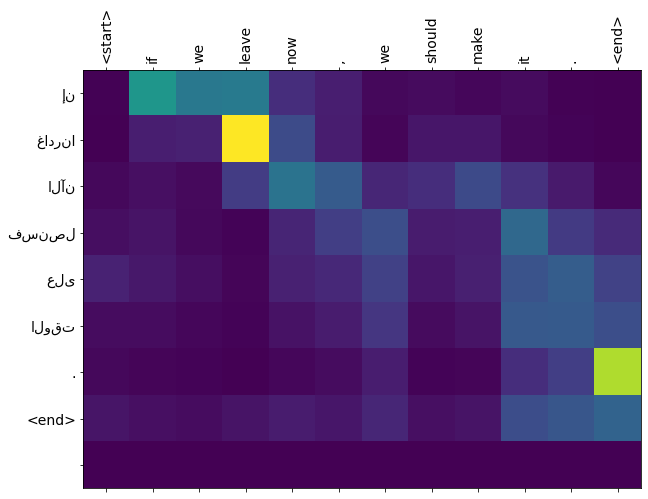

In [93]:
ind = np.random.randint(len(src_sentences))
sent = src_sentences[ind]
translate(sent)